In [1]:
from src.utils import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max.columns", None)

In [7]:
def load_df():
    df = pd.read_excel("src/20200705-GenRe-PfMasterData-0.39.xlsx", sheet_name = "GenRe-Mekong")

    df = df.loc[
                (df["Bcode\nValid"] == True) &
                (df.Species != "-")
                # & (df["Admission Sample"] == False)
                ].drop(columns = ["SeqNum", "Pf sample"])

    return df
    
df = load_df()

In [8]:
location_df = (df["AdmDiv1"]
               .value_counts()
               .reset_index()
               .rename(columns = {"AdmDiv1": "district"})
               )

location_df[["district_latitude", "district_longitude", "country"]] = location_df.district.apply(find_location_details).apply(pd.Series)

In [149]:
import plotly.express as px

fig = px.scatter_geo(location_df, lon = "district_longitude", lat = "district_latitude",
                     hover_data = ["district"],
                     hover_name = "country",
                     size = "count"
                     )

fig.update_geos(showcountries = True,
                lonaxis_range = [85, 115],
                lataxis_range = [5, 25])

fig.show()

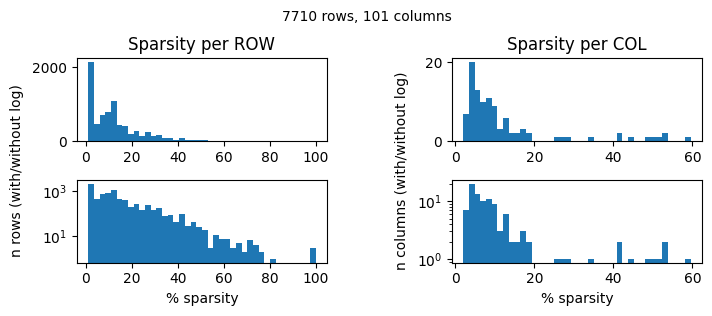

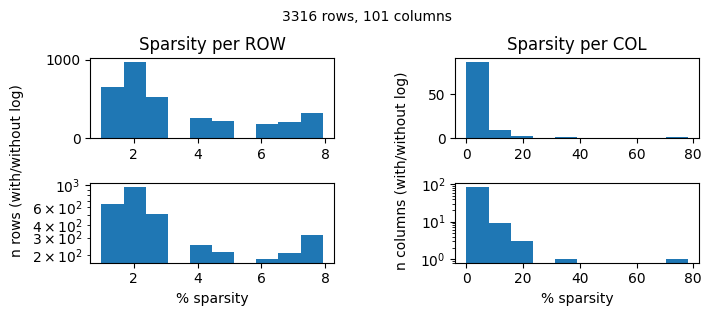

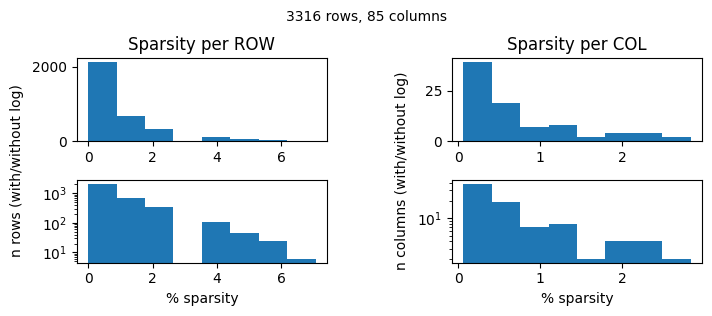

In [10]:
genetic_columns = [col for col in df.columns if "_" in col]

genetic_clustering_df = df[["SampleId"] + genetic_columns].replace("\n", "", regex = True).set_index("SampleId")

def generate_sparsity_plots(df, n_bins = 10):
    fig, axes = plt.subplots(2, 2, figsize = (7, 3))

    axes[0][0].sharex(axes[1][0])
    axes[0][0].set_title("Sparsity per ROW")
    axes[1][0].set_xlabel("% sparsity")
    axes[0][0].hist([100*(row == "X").sum() / len(row) for row in df.values], bins = n_bins)
    axes[1][0].hist([100*(row == "X").sum() / len(row) for row in df.values], bins = n_bins, log = "y")

    axes[0][1].sharex(axes[1][1])
    axes[0][1].set_title("Sparsity per COL")
    axes[1][1].set_xlabel("% sparsity")
    axes[0][1].hist([100*df[col].value_counts()["X"] / df[col].value_counts().sum() for col in df.columns], bins = n_bins)
    axes[1][1].hist([100*df[col].value_counts()["X"] / df[col].value_counts().sum() for col in df.columns], bins = n_bins, log = "y")

    
    fig.text(x = 0.5, y = 1, s = f"{df.shape[0]} rows, {df.shape[1]} columns", ha = "center")
    fig.text(x = 0, y = 0.5, s = f"n rows (with/without log)", ha = "center", va = "center", rotation = 90)
    fig.text(x = 0.55, y = 0.5, s = f"n columns (with/without log)", ha = "center", va = "center", rotation = 90)
    plt.tight_layout()
    plt.subplots_adjust(wspace = 0.5)
    plt.show()


generate_sparsity_plots(genetic_clustering_df, n_bins = 40)

cleaned_df_1 = genetic_clustering_df.loc[[100*(row == "X").sum() / len(row) < 8 for row in genetic_clustering_df.values]]

generate_sparsity_plots(cleaned_df_1)

cleaned_df_2 = cleaned_df_1.loc[:, [col for col in cleaned_df_1.columns if 100*cleaned_df_1[col].value_counts()["X"] / cleaned_df_1[col].value_counts().sum() < 3]]

generate_sparsity_plots(cleaned_df_2, n_bins = 8)

In [ ]:
encoder = lambda x: {
    "A": np.array([1.0, 0.0, 0.0, 0.0]),
    "T": np.array([0.0, 1.0, 0.0, 0.0]),
    "C": np.array([0.0, 0.0, 1.0, 0.0]),
    "G": np.array([0.0, 0.0, 0.0, 1.0]),
    "X": np.array([0.2, 0.2, 0.2, 0.2]),
    "N": np.array([0.7, 0.7, 0.7, 0.7])}[x]

mapped_df = cleaned_df_2.applymap(encoder)

encoded_df = pd.concat([mapped_df[col].apply(pd.Series).rename(columns = {i: f"{col}-{base}" for i, base in enumerate(["A", "T", "C", "G"])}) for col in mapped_df.columns], axis = 1)

In [119]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

def optimal_dbscan_fit(encoded_df, min_samples = 5):
    test_eps_values = np.arange(0.3, 10, 0.2)
    test_eps_columns = [f"eps={i:.01f}" for i in test_eps_values]
    genotype_columns = encoded_df.columns
    l_labels = []

    for eps in test_eps_values:
        dbscan_clustering = DBSCAN(eps = eps, min_samples = min_samples).fit(encoded_df.values)

        l_labels += [dbscan_clustering.labels_]

    eps_df = pd.DataFrame(l_labels).T
    eps_df.columns = test_eps_columns
    eps_df = pd.concat([encoded_df.reset_index(), eps_df], axis = 1).set_index("SampleId")
    
    l_percentage_minus_1 = []
    l_n_clusters = []
    l_errors = []
    for eps_col in test_eps_columns:
        eps_col_diffs = []
        l_percentage_minus_1 += [len(eps_df.loc[eps_df[eps_col] == -1]) / len(eps_df)]

        for cluster in eps_df[eps_col].unique():
            if cluster == -1:
                continue

            in_cluster_df = eps_df.loc[eps_df[eps_col] == cluster, genotype_columns]
            in_cluster_means = in_cluster_df.mean(axis = 0).to_numpy()

            # in_difference_from_in_mean = np.mean(in_cluster_df.subtract(in_cluster_means).abs().sum() / len(in_cluster_df))

            out_cluster_df = eps_df.loc[eps_df[eps_col] != cluster, genotype_columns]
            out_closest_to_in_mean = np.min(out_cluster_df.subtract(in_cluster_means).abs().sum(axis = 1) / len(out_cluster_df))

            eps_col_diffs += [out_closest_to_in_mean]
        
        l_n_clusters += [eps_df[eps_col].nunique()]
        l_errors += [np.sum(eps_col_diffs)]
    

    return pd.DataFrame({"epsilon": test_eps_values,
                         "% cluster -1": l_percentage_minus_1, 
                         "n clusters": l_n_clusters,
                         "cluster uniqueness": l_errors})


optimal_dbscan_fit(encoded_df)

,epsilon,% cluster -1,n clusters,cluster uniqueness
0,0.3,0.657720,62,0.132680
1,0.5,0.657720,62,0.132680
2,0.7,0.657720,62,0.132680
3,0.9,0.604343,70,0.201458
4,1.1,0.600724,71,0.217608
5,1.3,0.562425,78,0.364671
6,1.5,0.559107,76,0.368220
7,1.7,0.543727,80,0.437394
8,1.9,0.527744,83,0.507372
9,2.1,0.520808,83,0.551472


In [207]:
clustering = DBSCAN(eps = 5.7, min_samples = 5).fit(X)

resistance_df = df.copy(deep = True).set_index("SampleId").loc[encoded_df.index, ["Year",
                                                                                  "AdmDiv1",
                                                                                  "Artemisinin",
                                                                                  "Piperaquine",
                                                                                  "DHA-PPQ",
                                                                                  "Chloroquine",
                                                                                  "Pyrimethamine",
                                                                                  "Sulfadoxine",
                                                                                  "S-P",
                                                                                  "S-P-IPTp"]]


pca = PCA(n_components = 3)
pca_df = pd.DataFrame(pca.fit_transform(X), columns = ["PC1", "PC2", "PC3"])
pca_df.index = encoded_df.index

pca_df = pd.concat([pca_df, resistance_df, encoded_df], axis = 1)
pca_df["cluster"] = clustering.labels_
pca_df["cluster_str"] = clustering.labels_.astype(str)
pca_df["latitude"] = pca_df.AdmDiv1.map(dict(zip(location_df.district, location_df.district_latitude)))
pca_df["longitude"] = pca_df.AdmDiv1.map(dict(zip(location_df.district, location_df.district_longitude)))
pca_df["country"] = pca_df.AdmDiv1.map(dict(zip(location_df.district, location_df.country)))

In [208]:
# pca_df

In [210]:
import plotly.express as px

fig = px.scatter_3d(pca_df,
                    x = "PC1",
                    y = "PC2",
                    z = "PC3",
                    color = "cluster_str",
                    opacity = 0.3)
fig.show()

In [292]:
fig_df = pca_df.groupby(["Year", "cluster"]).apply(lambda x: pd.Series({"Count": len(x),
                                                                        "Longitude": x.longitude[0],
                                                                        "Latitude": x.latitude[0],
                                                                        "District": x.AdmDiv1[0],
                                                                        "Country": x.country[0],
                                                                        "cluster_str": x.cluster_str[0],
                                                                        })).reset_index()

buffer = [pd.DataFrame({"Year": Year,
                        "cluster": cluster,
                        "cluster_str": str(cluster),
                        "Count": 0,
                        "Longitude": 0,
                        "Latitude": 0,
                        "District": 0,
                        "Country": 0}, index = [0]) for cluster in fig_df.cluster.unique() for Year in fig_df.Year.unique()]
fig_df = pd.concat([fig_df] + buffer).sort_values(["Year", "cluster"]).reset_index(drop = True)
fig_df["Size"] = fig_df.Count.apply(lambda x: 3 + 5*np.log(x+1))

In [293]:
def spiral_offset(k, r_scale = 0.1, theta_scale = 0.6):
    offsets = []
    for i in range(k):
        theta = i * np.pi / 2
        radius = np.sqrt(i) * r_scale
        x = radius * np.cos(theta * theta_scale)
        y = radius * np.sin(theta * theta_scale)
        offsets += [[x, y]]
    return np.array(offsets).T

jitter_df = fig_df.groupby(["Year", "District"]).apply(lambda x: pd.Series({"cluster": list(x.cluster),
                                                                            "idx": list(x.index),
                                                                            "Longitude": np.array(x.Longitude),
                                                                            "Latitude": np.array(x.Latitude),
                                                                            })).reset_index()
jitter_df = jitter_df.loc[jitter_df.District != 0].reset_index(drop = True)
jitter_df.Longitude = jitter_df.Longitude.apply(lambda x: x + spiral_offset(len(x))[0])
jitter_df.Latitude = jitter_df.Latitude.apply(lambda x: x + spiral_offset(len(x))[1])

for i in jitter_df.index:
    fig_df.loc[jitter_df.loc[i, "idx"], "Longitude"] = jitter_df.loc[i, "Longitude"]
    fig_df.loc[jitter_df.loc[i, "idx"], "Latitude"] = jitter_df.loc[i, "Latitude"]

In [294]:
fig = px.scatter_geo(fig_df, lon = "Longitude", lat = "Latitude",
                     hover_name = "District",
                     size = "Size",
                     hover_data = {"Count": True, "Size": False},
                     color = "cluster_str",
                     animation_frame = "Year"
                     )

fig.update_geos(showcountries = True,
                lonaxis_range = [85, 115],
                lataxis_range = [5, 25])

fig.update_layout(legend = dict(
    orientation = "h",
    yanchor = "bottom",
    y = 1.02,
    xanchor = "right",
    x = 1
))

fig.show()

In [16]:
signature = pca_df.loc[pca_df.cluster != "-1"].groupby("cluster")[[col for col in pca_df.columns if "_" in col]].mean()
signature = signature.apply(lambda x: [min(v, 1-v) for v in x])

pca_df.loc[pca_df.cluster != "-1"]

# tweak DBSCAN - optimise by ensuring within-cluster sequence distances is lower than across-cluster sequences
# find clusters that are detected across X number of years
# dbscan allows pseudo lineage tree

# show that clusters are quite reliable by showing that their movement across time is quite steady and plausible

# select for clusters that persist across multiple years

# analyse momentum of strains in moving to neighbouring countries
# spot when one starts to displace another strain

# randomly assign animal names or something to make clusters more appealing

,PC1,PC2,PC3,Year,AdmDiv1,Artemisinin,Piperaquine,DHA-PPQ,Chloroquine,Pyrimethamine,Sulfadoxine,S-P,S-P-IPTp,Pf3D7_02_v3:470013-A,Pf3D7_02_v3:470013-T,Pf3D7_02_v3:470013-C,Pf3D7_02_v3:470013-G,Pf3D7_04_v3:881571-A,Pf3D7_04_v3:881571-T,Pf3D7_04_v3:881571-C,Pf3D7_04_v3:881571-G,Pf3D7_05_v3:369740-A,Pf3D7_05_v3:369740-T,Pf3D7_05_v3:369740-C,Pf3D7_05_v3:369740-G,Pf3D7_06_v3:900278-A,Pf3D7_06_v3:900278-T,Pf3D7_06_v3:900278-C,Pf3D7_06_v3:900278-G,Pf3D7_07_v3:1044052-A,Pf3D7_07_v3:1044052-T,Pf3D7_07_v3:1044052-C,Pf3D7_07_v3:1044052-G,Pf3D7_08_v3:413067-A,Pf3D7_08_v3:413067-T,Pf3D7_08_v3:413067-C,Pf3D7_08_v3:413067-G,Pf3D7_09_v3:900277-A,Pf3D7_09_v3:900277-T,Pf3D7_09_v3:900277-C,Pf3D7_09_v3:900277-G,Pf3D7_11_v3:1018899-A,Pf3D7_11_v3:1018899-T,Pf3D7_11_v3:1018899-C,Pf3D7_11_v3:1018899-G,Pf3D7_11_v3:1815412-A,Pf3D7_11_v3:1815412-T,Pf3D7_11_v3:1815412-C,Pf3D7_11_v3:1815412-G,Pf3D7_13_v3:1056452-A,Pf3D7_13_v3:1056452-T,Pf3D7_13_v3:1056452-C,Pf3D7_13_v3:1056452-G,Pf3D7_13_v3:1466422-A,Pf3D7_13_v3:1466422-T,Pf3D7_13_v3:1466422-C,Pf3D7_13_v3:1466422-G,Pf3D7_14_v3:137622-A,Pf3D7_14_v3:137622-T,Pf3D7_14_v3:137622-C,Pf3D7_14_v3:137622-G,Pf3D7_14_v3:2164225-A,Pf3D7_14_v3:2164225-T,Pf3D7_14_v3:2164225-C,Pf3D7_14_v3:2164225-G,Pf3D7_01_v3:145515-A,Pf3D7_01_v3:145515-T,Pf3D7_01_v3:145515-C,Pf3D7_01_v3:145515-G,Pf3D7_04_v3:139051-A,Pf3D7_04_v3:139051-T,Pf3D7_04_v3:139051-C,Pf3D7_04_v3:139051-G,Pf3D7_04_v3:286542-A,Pf3D7_04_v3:286542-T,Pf3D7_04_v3:286542-C,Pf3D7_04_v3:286542-G,Pf3D7_04_v3:529500-A,Pf3D7_04_v3:529500-T,Pf3D7_04_v3:529500-C,Pf3D7_04_v3:529500-G,Pf3D7_05_v3:796714-A,Pf3D7_05_v3:796714-T,Pf3D7_05_v3:796714-C,Pf3D7_05_v3:796714-G,Pf3D7_07_v3:1256331-A,Pf3D7_07_v3:1256331-T,Pf3D7_07_v3:1256331-C,Pf3D7_07_v3:1256331-G,Pf3D7_07_v3:461139-A,Pf3D7_07_v3:461139-T,Pf3D7_07_v3:461139-C,Pf3D7_07_v3:461139-G,Pf3D7_07_v3:619957-A,Pf3D7_07_v3:619957-T,Pf3D7_07_v3:619957-C,Pf3D7_07_v3:619957-G,Pf3D7_08_v3:417335-A,Pf3D7_08_v3:417335-T,Pf3D7_08_v3:417335-C,Pf3D7_08_v3:417335-G,Pf3D7_09_v3:163977-A,Pf3D7_09_v3:163977-T,Pf3D7_09_v3:163977-C,Pf3D7_09_v3:163977-G,Pf3D7_10_v3:317581-A,Pf3D7_10_v3:317581-T,Pf3D7_10_v3:317581-C,Pf3D7_10_v3:317581-G,Pf3D7_10_v3:336274-A,Pf3D7_10_v3:336274-T,Pf3D7_10_v3:336274-C,Pf3D7_10_v3:336274-G,Pf3D7_11_v3:1020397-A,Pf3D7_11_v3:1020397-T,Pf3D7_11_v3:1020397-C,Pf3D7_11_v3:1020397-G,Pf3D7_11_v3:1294107-A,Pf3D7_11_v3:1294107-T,Pf3D7_11_v3:1294107-C,Pf3D7_11_v3:1294107-G,Pf3D7_11_v3:1935227-A,Pf3D7_11_v3:1935227-T,Pf3D7_11_v3:1935227-C,Pf3D7_11_v3:1935227-G,Pf3D7_11_v3:477922-A,Pf3D7_11_v3:477922-T,Pf3D7_11_v3:477922-C,Pf3D7_11_v3:477922-G,Pf3D7_12_v3:1663492-A,Pf3D7_12_v3:1663492-T,Pf3D7_12_v3:1663492-C,Pf3D7_12_v3:1663492-G,Pf3D7_12_v3:2171901-A,Pf3D7_12_v3:2171901-T,Pf3D7_12_v3:2171901-C,Pf3D7_12_v3:2171901-G,Pf3D7_13_v3:1233218-A,Pf3D7_13_v3:1233218-T,Pf3D7_13_v3:1233218-C,Pf3D7_13_v3:1233218-G,Pf3D7_13_v3:2377887-A,Pf3D7_13_v3:2377887-T,Pf3D7_13_v3:2377887-C,Pf3D7_13_v3:2377887-G,Pf3D7_14_v3:2355751-A,Pf3D7_14_v3:2355751-T,Pf3D7_14_v3:2355751-C,Pf3D7_14_v3:2355751-G,Pf3D7_14_v3:3046108-A,Pf3D7_14_v3:3046108-T,Pf3D7_14_v3:3046108-C,Pf3D7_14_v3:3046108-G,Pf3D7_02_v3:714480-A,Pf3D7_02_v3:714480-T,Pf3D7_02_v3:714480-C,Pf3D7_02_v3:714480-G,Pf3D7_03_v3:155697-A,Pf3D7_03_v3:155697-T,Pf3D7_03_v3:155697-C,Pf3D7_03_v3:155697-G,Pf3D7_04_v3:1037656-A,Pf3D7_04_v3:1037656-T,Pf3D7_04_v3:1037656-C,Pf3D7_04_v3:1037656-G,Pf3D7_04_v3:648101-A,Pf3D7_04_v3:648101-T,Pf3D7_04_v3:648101-C,Pf3D7_04_v3:648101-G,Pf3D7_05_v3:1204155-A,Pf3D7_05_v3:1204155-T,Pf3D7_05_v3:1204155-C,Pf3D7_05_v3:1204155-G,Pf3D7_06_v3:1282691-A,Pf3D7_06_v3:1282691-T,Pf3D7_06_v3:1282691-C,Pf3D7_06_v3:1282691-G,Pf3D7_06_v3:1289212-A,Pf3D7_06_v3:1289212-T,Pf3D7_06_v3:1289212-C,Pf3D7_06_v3:1289212-G,Pf3D7_07_v3:1066698-A,Pf3D7_07_v3:1066698-T,Pf3D7_07_v3:1066698-C,Pf3D7_07_v3:1066698-G,Pf3D7_07_v3:1213486-A,Pf3D7_07_v3:1213486-T,Pf3D7_07_v3:1213486-C,Pf3D7_07_v3:1213486-G,Pf3D7_07_v3:704373-A,Pf3D7_07_v3:704373-T,Pf3D7_07_v3:704373-C,Pf3D7_07_v3:704373-G,Pf3D7_08_v3:1313202-A,P